In [2]:
import pandas as pd
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import *

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import r2_score, make_scorer
from sklearn.feature_selection import mutual_info_regression
from sklearn.manifold import LocallyLinearEmbedding as LLE, TSNE
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from mpl_toolkits import mplot3d

from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Data Loading and preprocessing
- Filling using mean and removing constant columns
- All features assumed to be continuous

### still need to do outlier detection 

In [3]:
train = pd.read_csv("X_train.csv")
train.columns

y_train = pd.read_csv("y_train.csv")

constant_cols = train.columns[train.std() == 0]
data_columns = train.columns.difference({"id"}.union(constant_cols))

X_train = train[data_columns].fillna(train.mean())
Y_train = y_train.y

# Feature Selection 
- Also need to try keeping all cols with nonzero mutual information then doing SVD
- Also need to try top n best random forest features

In [4]:
mi = mutual_info_regression(X_train, Y_train, discrete_features=False, random_state=0)
mutual_info = pd.Series(mi, index=X_train.columns)

In [5]:
best_features = mutual_info.sort_values(ascending=False).index[:36]

X_small = X_train[best_features]

# Visualization
There seem to be two main clusters

In [6]:
tsne_local = TSNE(n_components=2, perplexity=5, random_state=0)
X_local = tsne_local.fit_transform(X_small)

In [7]:
tsne_global = TSNE(n_components=2, perplexity=30, random_state=0)
X_global = tsne_global.fit_transform(X_small)

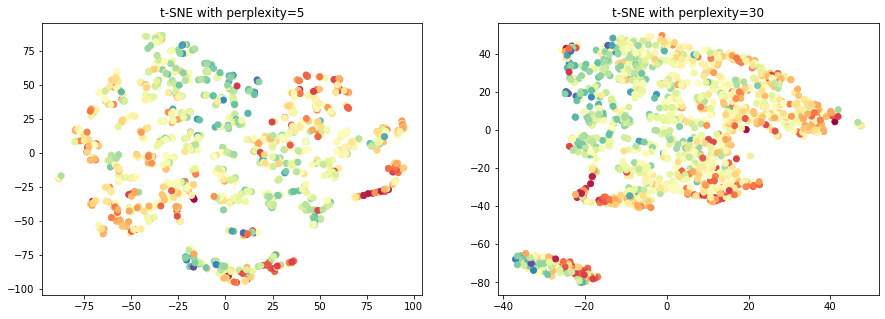

In [8]:
fig, axes = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)

axes[0].scatter(X_local[:, 0], X_local[:, 1], c=Y_train, cmap=plt.cm.Spectral)
axes[0].set_title(f"t-SNE with perplexity={tsne_local.perplexity}")

axes[1].scatter(X_global[:, 0], X_global[:, 1], c=Y_train, cmap=plt.cm.Spectral)
axes[1].set_title(f"t-SNE with perplexity={tsne_global.perplexity}")
plt.show()

In [9]:
kmeans = KMeans(n_clusters=2, random_state=0)

kmeans.fit(X_small)
clusters = kmeans.labels_

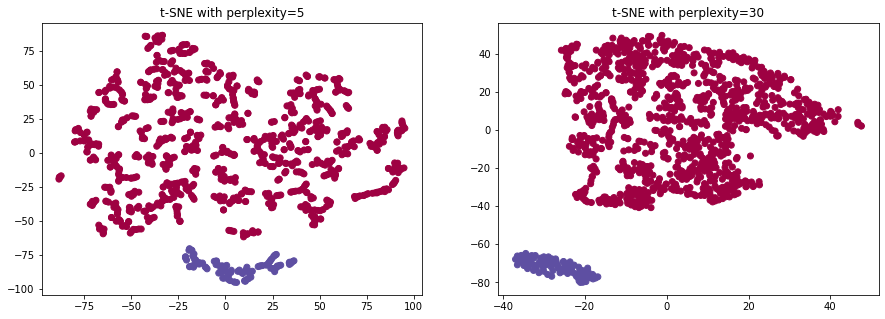

In [10]:
fig, axes = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)

axes[0].scatter(X_local[:, 0], X_local[:, 1], c=clusters, cmap=plt.cm.Spectral)
axes[0].set_title(f"t-SNE with perplexity={tsne_local.perplexity}")

axes[1].scatter(X_global[:, 0], X_global[:, 1], c=clusters, cmap=plt.cm.Spectral)
axes[1].set_title(f"t-SNE with perplexity={tsne_global.perplexity}")

plt.show()

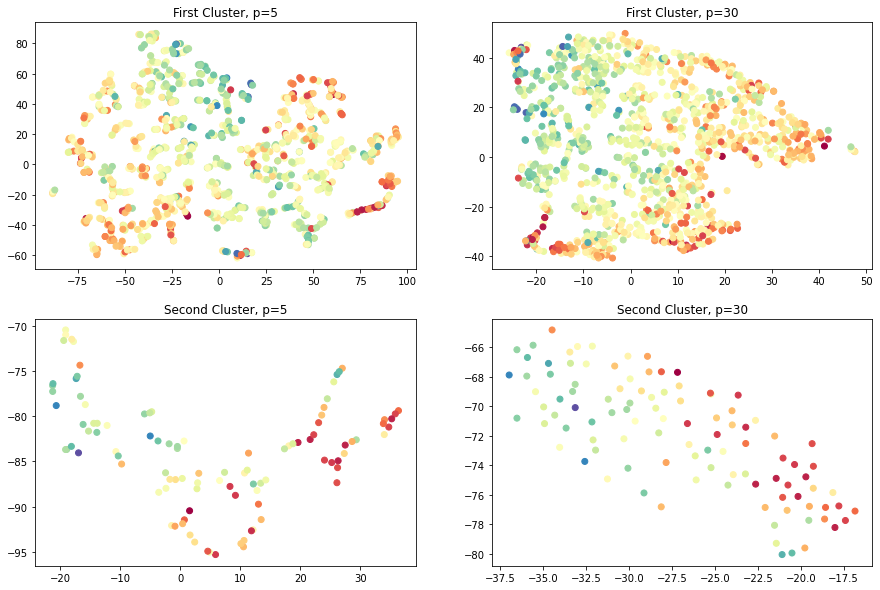

In [26]:
def plot_clusters():
    X_local_first, X_local_second = X_local[clusters == 0], X_local[clusters == 1]
    X_global_first, X_global_second = X_global[clusters == 0], X_global[clusters==1]



    fig, axes = plt.subplots(2, 2)

    fig.set_figheight(10)
    fig.set_figwidth(15)

    axes[0, 0].scatter(X_local_first[:, 0], X_local_first[:, 1], c=Y_train[clusters==0], cmap=plt.cm.Spectral)
    axes[0, 0].set_title(f"First Cluster, p={tsne_local.perplexity}")

    axes[1, 0].scatter(X_local_second[:, 0], X_local_second[:, 1], c=Y_train[clusters==1], cmap=plt.cm.Spectral)
    axes[1, 0].set_title(f"Second Cluster, p={tsne_local.perplexity}")

    axes[0, 1].scatter(X_global_first[:, 0], X_global_first[:, 1], c=Y_train[clusters==0], cmap=plt.cm.Spectral)
    axes[0, 1].set_title(f"First Cluster, p={tsne_global.perplexity}")

    axes[1, 1].scatter(X_global_second[:, 0], X_global_second[:, 1], c=Y_train[clusters==1], cmap=plt.cm.Spectral)
    axes[1, 1].set_title(f"Second Cluster, p={tsne_global.perplexity}")

    plt.show()
    
plot_clusters()

### Outlier Detection 

Inlier ratio: 92.987%


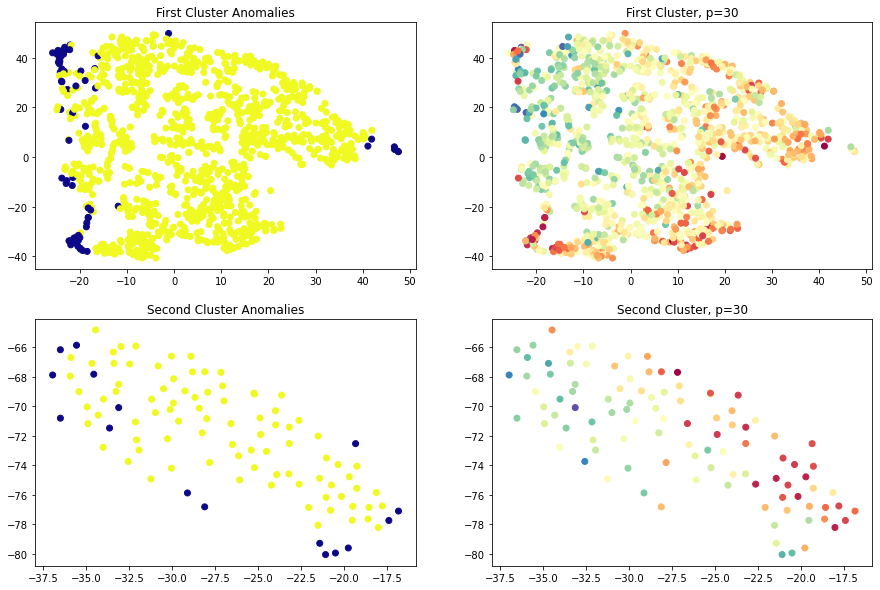

In [104]:
best_features = mutual_info.sort_values(ascending=False).index[:98]
X_small = X_train[dimi_features]

out = IsolationForest(n_estimators=10000)
anomalies = out.fit_predict(X_small)
anomalies = (anomalies + 1) / 2
print(f"Inlier ratio: {100 * anomalies.sum() / len(anomalies):.3f}%")

def plot_anomalies():
    X_global_first, X_global_second = X_global[clusters == 0], X_global[clusters==1]

    fig, axes = plt.subplots(2, 2)

    fig.set_figheight(10)
    fig.set_figwidth(15)

    axes[0, 0].scatter(X_global_first[:, 0], X_global_first[:, 1], c=anomalies[clusters==0], cmap=plt.cm.plasma)
    axes[0, 0].set_title(f"First Cluster Anomalies")

    axes[1, 0].scatter(X_global_second[:, 0], X_global_second[:, 1], c=anomalies[clusters==1], cmap=plt.cm.plasma)
    axes[1, 0].set_title(f"Second Cluster Anomalies")

    axes[0, 1].scatter(X_global_first[:, 0], X_global_first[:, 1], c=Y_train[clusters==0], cmap=plt.cm.Spectral)
    axes[0, 1].set_title(f"First Cluster, p={tsne_global.perplexity}")

    axes[1, 1].scatter(X_global_second[:, 0], X_global_second[:, 1], c=Y_train[clusters==1], cmap=plt.cm.Spectral)
    axes[1, 1].set_title(f"Second Cluster, p={tsne_global.perplexity}")

    plt.show()
    
plot_anomalies()

# Training
Starting on the first cluster

In [105]:
def train_gaussian_process(X, Y):
    X_trn, X_val, Y_trn, Y_val = train_test_split(X, Y, train_size=0.8, random_state=0)
    
    poly = (DotProduct() + 1)**2
    kernel = RationalQuadratic() + RBF() * WhiteKernel() ** 1
    
    gp = GaussianProcessRegressor(kernel=kernel, random_state=0)
    gp.fit(X_trn, Y_trn)

    Y_pred = gp.predict(X_val)
    Y_pred_trn = gp.predict(X_trn)

    print(f"Training score: {r2_score(Y_trn, Y_pred_trn)}")
    print(f"Testing score: {r2_score(Y_val, Y_pred)}")
    print(f"Final kernel: {gp.kernel_}")
    
    
    return gp, Y_pred_trn * Y.std() + Y.mean(), Y_pred * Y.std() + Y.mean()

In [106]:
def plot_train_test_results(X, Y, Y_pred_trn, Y_pred):
    X_trn, X_val, Y_trn, Y_val = train_test_split(X, Y, train_size=0.8, random_state=0)
    fig, axes = plt.subplots(2, 2)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    axes[0, 0].scatter(X_val[:, 0], X_val[:, 1], c=Y_val, cmap=plt.cm.Spectral)
    axes[0, 0].set_title("Ground Truth (Validation Set)")

    axes[0, 1].scatter(X_val[:, 0], X_val[:, 1], c=Y_pred, cmap=plt.cm.Spectral)
    axes[0, 1].set_title("Predictions (Validation Set)")

    axes[1, 0].scatter(X_trn[:, 0], X_trn[:, 1], c=Y_trn, cmap=plt.cm.Spectral)
    axes[1, 0].set_title("Ground Truth (Training Set)")

    axes[1, 1].scatter(X_trn[:, 0], X_trn[:, 1], c=Y_pred_trn, cmap=plt.cm.Spectral)
    axes[1, 1].set_title("Predictions (Training Set)")

In [107]:
best_features = mutual_info.sort_values(ascending=False).index[:64]
dimi_features = [85, 262, 289, 302, 315, 360, 403, 447, 462, 482, 496, 537, 575, 597, 615, 662, 685, 776, 785]
dimi_features = [train.columns[i + 1] for i in dimi_features]
dimi_train = train[best_features]
dimi_train = dimi_train

In [108]:
scaler = StandardScaler()

# X_imp = IterativeImputer().fit_transform(dimi_train)
X_imp = dimi_train.fillna(dimi_train.mean())

X_train_norm = scaler.fit_transform(X_imp)

scaler_y = StandardScaler()
Y_train_norm = scaler_y.fit_transform(Y_train.to_numpy()[:, np.newaxis])

In [109]:
X, Y = X_train_norm, Y_train_norm

### Best results:
- Train across both clusters, n_features=64

In [110]:
gpr, Y_pred_trn, Y_pred = train_gaussian_process(X, Y)

Training score: 0.9999999997219803
Testing score: 0.6462077881815553
Final kernel: RationalQuadratic(alpha=0.737, length_scale=3.85) + RBF(length_scale=1) * WhiteKernel(noise_level=1e-05) ** 1


In [86]:
kernel = RationalQuadratic()
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0).fit(X, Y)

In [27]:
gpr.score(X, Y)

1.0

In [42]:
X_test = pd.read_csv("X_test.csv")
X_test.index = X_test.id.astype("int")
X_test = X_test.drop(columns="id")
X_test = X_test.fillna(X_test.mean())

In [44]:
X_test = X_test[best_features]
X_test_n = scaler.transform(X_test)

Y_pred_n = gpr.predict(X_test_n)

In [51]:
Y_pred = scaler_y.inverse_transform(Y_pred_n)
Y_pred = pd.Series(Y_pred[:, 0], index=X_test.index, name="y")
Y_pred.to_csv("predictions_unified_best64.csv")

In [311]:
best_36 = mutual_info.sort_values(ascending=False).index[:36]
best_150 = mutual_info.sort_values(ascending=False).index[:150]
test_clusters = kmeans.predict(X_test[best_36])
X_test_first = X_test[test_clusters == 0][best_150]
X_test_second = X_test[test_clusters == 1][best_150]

In [312]:
X_test_first_norm = X_scaler_0.transform(X_test_first)
X_test_second_norm = X_scaler_1.transform(X_test_second)

Y_pred_first = gpr_0.predict(X_test_first_norm)[:, 0]
Y_pred_second = gpr_1.predict(X_test_second_norm)[:, 0]

In [329]:
Y_0 = Y_scaler_0.inverse_transform(Y_pred_first)
Y_1 = Y_scaler_1.inverse_transform(Y_pred_second)

In [333]:
Y_pred_first = pd.Series(Y_0, index=X_test_first.index)
Y_pred_second = pd.Series(Y_1, index=X_test_second.index)
Y_pred = pd.concat((Y_pred_first, Y_pred_second))

In [337]:
Y_pred.name = "y"
Y_pred.to_csv("predictions_per_cluster.csv")

In [348]:
Y_pred_unified = pd.read_csv("predictions_unified.csv", index_col="id").y
Y_pred_unified

id
0      71.528136
1      69.006209
2      67.222864
3      71.159429
4      68.025844
         ...    
771    57.651127
772    72.970075
773    74.186192
774    71.772829
775    70.297060
Name: y, Length: 776, dtype: float64

In [350]:
Y_avg = (Y_pred + Y_pred_unified) / 2
Y_avg.to_csv("predictions_averaged.csv")
Y_avg

id
0      71.210159
1      69.302697
2      67.325262
3      70.893409
4      68.248619
         ...    
771    58.297825
772    73.056901
773    74.434505
774    71.592473
775    70.016116
Name: y, Length: 776, dtype: float64

In [343]:
Y_round = Y_avg.round()
Y_round.to_csv("predictions_averaged_rounded.csv")

In [347]:
Y_unified = pd.read_csv("predictions_unified.csv", index_col="id").y
Y_unified.round().to_csv("predictions_unified_rounded.csv")